In [1]:
import pandas as pd
import time
import numpy as np
import re
import pickle
import string, unicodedata
from joblib import dump
from sklearn.decomposition import PCA

In [2]:
def getData(alamat):
    lineList = list()
    #with open(dir_path + '/' + alamat) as f:
    with open(alamat) as f:
        for line in f:
            lineList.append(line.rstrip('\n'))
    return lineList

In [3]:
data_ = pd.read_excel('data/data_bersih_ngram_tanpa_stemmer.xlsx') #data baru
latih_cm = data_['komentar'].tolist()
label_cm = data_['label'].tolist()
len(latih_cm)

3198

In [4]:
alamata = ['ID-OpinionWords-master/positive.txt', 'ID-OpinionWords-master/negative.txt']
kamus_ = list()
for i in alamata:
    kamus_+=getData(i)
    
kamus = list()
for i in kamus_:
    i = i.replace(" tdk ",'tidak').replace(" yng ",'yang').replace(" yg ",'yang').replace(" dg ",'dengan').replace(" dgn" ,'dengan')
    i = i.replace(" ", "_")
    kamus.append(i)
    i = i.split()
    if i[-1]=='-':
        print(i)
kosa_kata = list()
for i in latih_cm:
    for j in i.split():
        if j in kamus:
            kosa_kata.append(j)
kosa_kata = list(set(kosa_kata))
print(len(kamus_))

3584


In [5]:
def save_gdiganti(kosa_kata):
    with open("korpus_l.txt", "w") as f:
        for s in kosa_kata:
            f.write(str(s) +"\n")
            
save_gdiganti(kosa_kata)

In [6]:
#Proses TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
#membuat TF-IDF
#f = open("model/feature_balance.txt")
#kosa_kata = f.read().split()

tfidf = TfidfVectorizer(vocabulary = kosa_kata)

tfidf_matrix_ = tfidf.fit_transform(latih_cm) #For CM
tfidf_matrix_save = tfidf.fit(latih_cm)
print(tfidf_matrix_.shape)
X_ = tfidf_matrix_.toarray()
X = X_
Y_ = np.array(label_cm)
Y = Y_
dump(tfidf_matrix_save, 'model/tfdf_model_lexicon.joblib')

(3198, 304)


['model/tfdf_model_lexicon.joblib']

Positive    1762
Negative    1436
Name: label, dtype: int64


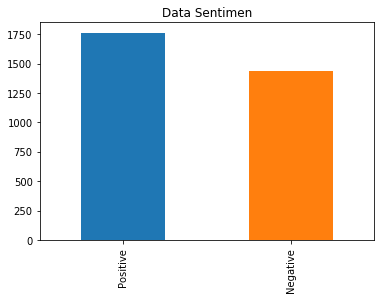

In [8]:
pca = PCA(n_components=2)
pd.value_counts(data_['label']).plot.bar(title='Data Sentimen')
print(pd.value_counts(data_['label']))

In [9]:
#proses pemodelan
#Import Library
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score

In [10]:
#Parameter SVM
C = 1.8
gamma = 0.6

In [11]:
#K-Fold Validation

K = 10 #pembagian data uji dan data latih
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score #, precision_score, recall_score
kf= KFold(n_splits=K) 

cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)

akurasi_svm = []

for train_index, test_index in kf.split(X):
    #membagi data latih dan data uji
    X_train, X_test = X[train_index], X[test_index] #pembagian data latih
    y_train, y_test = Y[train_index], Y[test_index]
    
    #Melatih Model 
    mSVM = cSVM.fit(X_train, y_train) #SVM

    #proses prediksi
    P_SVM = mSVM.predict(X_test)

    #menyimpan hasil akurasi tiap iterasi
    akurasi_svm.append(accuracy_score(y_test, P_SVM))
    
rerata_akurasi_svm = sum(akurasi_svm)/len(akurasi_svm)

print("Hasil K-Fold SVM")
print("   Rerata akurasi           :",rerata_akurasi_svm)
print("   Rerata akurasi (round)   :",round(rerata_akurasi_svm,2))
dic1 = {"iterasi ke-":[x+1 for x in range(10)], "akurasi":akurasi_svm}
pd.DataFrame.from_dict(dic1)

Hasil K-Fold SVM
   Rerata akurasi           : 0.6948530564263322
   Rerata akurasi (round)   : 0.69


,iterasi ke-,akurasi
0,1,0.700000
1,2,0.740625
2,3,0.784375
3,4,0.634375
4,5,0.693750
5,6,0.406250
6,7,0.768750
7,8,0.690625
8,9,0.695925
9,10,0.833856


In [12]:
rerata_akurasi_svm

0.6948530564263322

# Proses Confusion Matrix untuk SVM

Positive    1721
Negative    1416
Name: label, dtype: int64

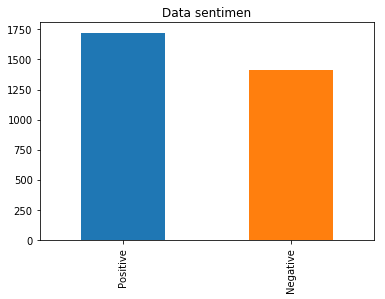

In [13]:
index_train = [x for x in range(3137)]
cm_Y = Y_[index_train]
dc = {"label":cm_Y}
cd = pd.DataFrame(dc, columns=['label'])
pd.value_counts(cd['label']).plot.bar(title='Data sentimen')
pd.value_counts(cd['label'])

In [14]:
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix


index_train = [x for x in range(3137)]
index__test = [x for x in range(3137, 3187)]

cm_X = X_[index_train]
cm_Y = Y_[index_train]
cm_X_test = X_[index__test]
cm_Y_test = Y_[index__test]

X_train = cm_X
X_test = cm_X_test

y_train = cm_Y
y_test = cm_Y_test

class_names = ['Positive', 'Negative']

classifier = svm.SVC(kernel='rbf', C=C, gamma=gamma) #Model SVM
y_pred = classifier.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
print("SVM")
cnf_matrix = confusion_matrix(y_test, y_pred) # inti
print(cnf_matrix)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
tp= cm [0][0]
fn= cm [0][1]
fp= cm [1][0]
tn= cm [1][1]
cm_akurasi = (tp+tn)/(tp+tn+fp+fn)
cm_precision = tp/(tp+fp)
cm_recall = tp/(tp+fn)

f_measure = 2*(cm_precision*cm_recall)/(cm_precision+cm_recall)
print("   F-Measure (SVM)")
print("   ----------------")
print("   akurasi   : ", cm_akurasi)
print("   precision : ", cm_precision)
print("   recall    : ", cm_recall)
print("   f-Measure : ", f_measure)


SVM
[[14  4]
 [ 6 26]]
   F-Measure (SVM)
   ----------------
   akurasi   :  0.7951388888888888
   precision :  0.8057553956834532
   recall    :  0.7777777777777778
   f-Measure :  0.7915194346289752


# Simpan Model

In [15]:
cSVM = svm.SVC(kernel='rbf', gamma=gamma, C=C)
#Melatih Model untuk data secara keseluruhan (X dan Y)
cSVM = cSVM.fit(X, Y) #SVN

#save models
dump(cSVM, 'model/svm_model_lexicon.joblib')

['model/svm_model_lexicon.joblib']